In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import uproot
import ROOT
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.integrate as intg 
from scipy.stats import norm
from numpy.random import normal
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
import sipm.util.functions as func
from datetime import datetime

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


## Functions defined here

In [2]:
def load_data(file_list, channel_list, volt):
    df_ch = {}
    dt = 0
    for ch in channel_list:
        df_ch[ch] = []
        for f in file_list:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            df_ch[ch].append(df)
            if ch==-1:
                dt = datetime(*np.array(df['start_datetime'][:6]).astype(int))
            df = None
        df_ch[ch] = pd.concat(df_ch[ch]).sort_index()
        if ch!=-1:
            df_ch[ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)            
    df_ch = pd.concat(list(df_ch.values()),axis=1)
    return df_ch, dt

def convert_to_pe(df_data,df_pe_scale,channels):
    pe_ch = df_data[[f'integral_10p00us_{ch}' for ch in range(8)]]
    pe_ch.columns = np.arange(8)
    pe_ch = pe_ch/df_pe_scale
    df_pe = pe_ch.iloc[:,channels].sum(axis=1)
    df_pe.name = 'pe_' + ''.join([str(c) for c in channels])
    pe_ch = None
    return df_pe

def get_bsl_filt(df_data,channels,rms_thre_ch):
    df_bsl_filt = {}
    for ch in channels:
        df_bsl_filt[f'bsl_filt_{ch}'] = df_data[f'baseline_rms_{ch}']<rms_thre_ch[ch]
        # print(df_bsl_filt[f'bsl_filt_{ch}'].sum())
    df_bsl_filt = pd.DataFrame(df_bsl_filt)
    df_bsl_filt['bsl_filt'] =  df_bsl_filt[[f'bsl_filt_{ch}' for ch in channels]].all(axis=1)
    return df_bsl_filt

def get_bsl_rms_hist(df_data,channels,bins,range):
    hist_ch = {}
    for ch in channels:
        hist_ch[ch] = np.histogram(df_data[f'baseline_rms_{ch}'], bins=bins, range=range)
    return hist_ch

def get_bsl_mean_hist(df_data,channels,bsl_filt,bins,range):
    hist_ch = {}
    for ch in channels:
        if bsl_filt:
            hist_ch[ch] = np.histogram(df_data.loc[df_data[f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], bins=bins, range=range)
        else:
            hist_ch[ch] = np.histogram(df_data[f'baseline_mean_{ch}'], bins=bins, range=range)
    return hist_ch

def get_sat_filt(df_data,channels,sat_list):
    df_sat_filt = {}
    for ch in channels:
        df_sat_filt[f'sat_filt_{ch}'] = df_data[f'amplitude_{ch}']<sat_list[ch]
    df_sat_filt = pd.DataFrame(df_sat_filt)
    df_sat_filt['sat_filt'] =  df_sat_filt[[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    return df_sat_filt

def get_fp_filt(df_data,channel_groups,fp_dict,length):
    df_fp_filt = {}
    for g in channel_groups:
        df_fp_filt[f'fp_filt_{g}'] = (df_data[f'fprompt_{length}_{g}']>fp_dict[g][0]) & (df_data[f'fprompt_{length}_{g}']<fp_dict[g][1])
    df_fp_filt = pd.DataFrame(df_fp_filt)
    df_fp_filt['fp_filt'] =  df_fp_filt[[f'fp_filt_{g}' for g in channel_groups]].all(axis=1)
    return df_fp_filt

def get_fp_hist2d(df_data,channel_groups,length,bins_xy,range_xy,log_scale):
    hist2d_g = {}
    for g in channel_groups:
        filt = df_data['bsl_filt']
        hist2d_g[g] = list(np.histogram2d(
            df_data[f'pe_{g}'][filt], 
            df_data[f'fprompt_{length}_{g}'][filt], 
            bins=bins_xy, range=range_xy
        ))
        temp = hist2d_g[g][0].T
        hist2d_g[g][0], hist2d_g[g][1] = np.meshgrid(
            hist2d_g[g][1], hist2d_g[g][2]
        )
        if log_scale:
            hist2d_g[g][2] = np.log10(temp)
        else:
            hist2d_g[g][2] = temp
    return hist2d_g

def get_fs_nofs_hist2d(df_data,bsl_filt,fp_filt,sat_filt,bins_xy,range_xy,log_scale):
    filt = np.ones(df_data.shape[0])
    if bsl_filt:
        filt = filt & df_data['bsl_filt']
    if fp_filt:
        filt = filt & df_data['fp_filt_01234567']
    if sat_filt:
        filt = filt & df_data['sat_filt']
    hist2d = list(np.histogram2d(
        df_data['nofs_pe'][filt], 
        df_data['fs_pe'][filt], 
        bins=bins_xy, range=range_xy
    ))
    temp = hist2d[0].T
    hist2d[0], hist2d[1] = np.meshgrid(
        hist2d[1], hist2d[2]
    )
    if log_scale:
        hist2d[2] = np.log10(temp)
    else:
        hist2d[2] = temp
    return hist2d

## Read calibration file and get PE scale

In [3]:
calib = {}
pe_scale = {}
voltages = [92,94,96,98,100]
for volt in voltages:
    calib[volt] = pd.read_hdf('data/calibration_liq6_2023-12-13.h5', key=f'{volt}V')
    pe_scale[volt] = calib[volt]['Qavg']/(1-calib[volt]['DiCT'])

## G4DS simulation (Compton scattering + UV photon transport)

Text(0.5, 1.0, 'Geant-4 Spectra')

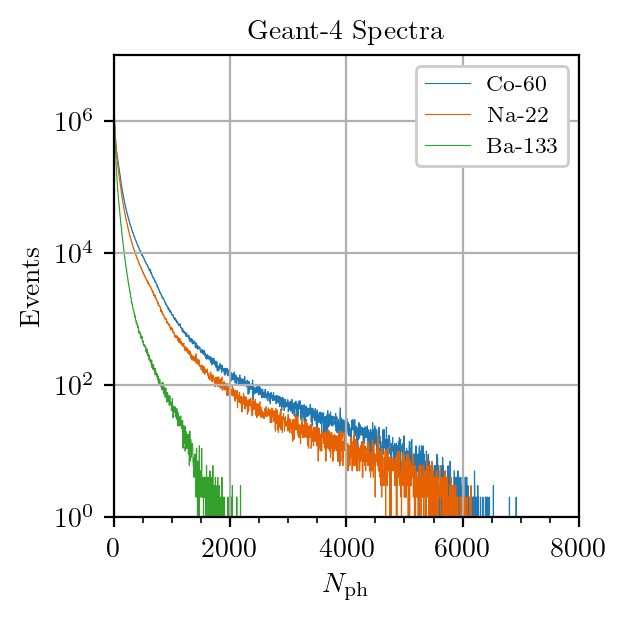

In [4]:
src = {'Co-60':'co60','Na-22':'na22','Ba-133':'ba133','Eu-152':'eu152'}
hist_sim = {}
plt.figure(0,figsize=(3,3))
for S,s in src.items():
    rtf = uproot.open(f'data/pe_hist/no_reflection/pu_lar_{s}_hist.root')
    hist_sim[S] = rtf['nph_nofs_1247'].to_numpy()
    if s!='eu152':
    	plt.stairs(hist_sim[S][0],hist_sim[S][1],linewidth=0.4,label=S)
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Events')
plt.legend(loc='upper right')
plt.title('Geant-4 Spectra')

## Detector response model
The number of PE follows the distribution
$$N_{\rm PE} \sim \mathcal{N}(\mu=N_{\rm ph}L_r, \sigma=\sqrt{F\mu}),$$
where $N_{\rm ph}$ is the number of photons arriving at the SiPMs (from G4DS), $L_r\equiv \varepsilon S/S_{\rm sim}$, $\varepsilon$ is the SiPMs' photo-detection efficiency (PDE), $S_{\rm sim}$ is the LAr scintillation yield used in G4DS (probably $1\rm ph/19.5eV=51.3ph/keV$), $S$ is the true scintillation yield ($\approx 40\rm ph/keV$ for pure LAr, to be measured for Xe-doped LAr), and $F$ is the Fano factor of the SiPMs due to correlated avalanches.

In [5]:
class DetectorSmearing():
    def __init__(self, fano, hist_in):
        self.hist_in_bin = hist_in[1]
        self.hist_in_width = self.hist_in_bin[1]-self.hist_in_bin[0]
        self.hist_in_count = hist_in[0]/np.sum(hist_in[0])/self.hist_in_width # normalized
        self.fano = fano

    def response_matrix(self, pe_in, pe_out, pde):
        pe_det = pde*pe_in
        smear2 = 0
        return norm.pdf(pe_out, loc=pe_det, scale=np.sqrt(self.fano*pe_det + smear2**2*pe_det**2))

    def get_spectrum(self, bins, n, pde):
        self.hist_out_bin = bins
        bin_cen_in = (self.hist_in_bin[1:]+self.hist_in_bin[:-1])/2
        bin_cen_out = (self.hist_out_bin[1:]+self.hist_out_bin[:-1])/2
        pe_out_mesh, pe_in_mesh = np.meshgrid(bin_cen_out, bin_cen_in)
        self.hist_out_count = self.hist_in_count @ self.response_matrix(pe_in_mesh, pe_out_mesh, pde)
        return n*self.hist_out_count, self.hist_out_bin
        
    def fit_to_data(self, data, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            n, pde = x[0], x[1]
            data_y, data_bin = args[0], args[1]
            bincen = (data_bin[1:] + data_bin[:-1])/2
            ans = (data_y-self.get_spectrum(data_bin, n, pde)[0])
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (bincen<fit_range[1]) & (bincen>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data,bounds=(0,np.inf))
        cov = np.linalg.inv(res.jac.T@res.jac)
        return res.x, cov
        

## Change channel mapping in calibration file from liq5

In [6]:
# store_in = pd.HDFStore('data/calibration_liq5_2023-12-13.h5')
# keys = store_in.keys()
# store_out = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# for k in keys:
#     df = store_in.get(k)
#     df['channel'] = [0,5,6,3,4,1,2,7]
#     df = df.sort_values('channel')
#     df.index = df['channel'].to_numpy()
#     df['max_amp'] = [1490]*4+[1440]*4
#     store_out.put(k,df)
# store_out.close()

In [7]:
# store_new = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# df = store_new.get('98V')
# print(df)
# store_new.close()

## Visualize waveforms from original binary files

In [8]:
# evid = np.arange(0, 10)
# # evid = [ 11  ,40 , 88, 115 ,134 ,138 ,141 ,146 ,153, 166]
# dset = wfd.WaveformDataset(
#     path='/scratch/gpfs/GALBIATI/data/sipm/xenon_doping/2024-05-07/2024-05-07_volt_98_light_scintillation_source_na22_xenon_0_cond_gamma/7/', 
#     pol=-1, 
#     channels=range(8))
# wfs = []
# for ch in np.arange(8):
#     wfs.append(dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)[0])
# wfs = np.array(wfs)
# print(wfs.shape)
# for i in range(wfs.shape[1]):
#     plt.figure(i, figsize=(3, 3))
#     for ch in range(wfs.shape[0]):
#         plt.plot(dset.ch[ch].time, wfs[ch,i]+ch*50, label=f'Ch{ch}', linewidth=0.5)
#     plt.legend(loc='upper right', fontsize=5)
#     plt.xlabel(r'Time [$\mu s$]')
#     plt.ylabel(r'Voltage [A.U.]')
#     plt.minorticks_on()
#     plt.grid()
#     plt.xlim(0, 20)
#     plt.ylim(-60, 400)
#     plt.title(f'Event No. {evid[i]}')

# 1. Pure LAr All Sources 02/23

In [9]:
path = "/scratch/gpfs/as111/results/"
sources = ['Na22','AmBe']
sources_lower = ['na22','ambe']
types = ['gamma','neutron_2pe']
xe_conc = [0,0.1,0.2,0.3,0.4,0.7,1.0,1.5,2.0,2.7]
cond = [f'{s} {x}ppm' for x in xe_conc for s in sources]
files = [glob(f'{path}*/*cond_{t}*source_{s}*xenon_{i}*pulse_liq7.h5') for i in range(len(xe_conc)) for (t,s) in zip(types,sources_lower)] 
for f in files:
	print(len(f), f)

20 ['/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run16_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run0_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run12_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run2_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run13_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run4_scintillation_pulse_liq7.h5', '/scratch/gpfs/as111/results/2024-05-07/2024-05-07_volt_98_light_scintillation_cond_gamma_source_na22_xenon_0_run8_scintill

In [10]:
data = {}
channels = np.arange(-1,8)
volt = 98
date_time = []
for i, c in enumerate(cond):
    data[c], dt = load_data(files[i],channels,volt)
    print(f'{c}: {data[c].shape[0]} events {dt}')
    date_time.append(dt) 
print('columns: ', list(data[cond[0]].columns))

Na22 0ppm: 1005271 events 2024-05-07 13:44:33
AmBe 0ppm: 499561 events 2024-05-08 13:43:54
Na22 0.1ppm: 502912 events 2024-05-14 15:31:56
AmBe 0.1ppm: 749394 events 2024-05-14 13:34:58
Na22 0.2ppm: 502858 events 2024-05-16 17:52:03
AmBe 0.2ppm: 749336 events 2024-05-16 13:43:27
Na22 0.3ppm: 502703 events 2024-05-20 16:14:20
AmBe 0.3ppm: 749435 events 2024-05-20 13:00:48
Na22 0.4ppm: 502711 events 2024-05-21 10:47:23
AmBe 0.4ppm: 749355 events 2024-05-22 11:15:09
Na22 0.7ppm: 502984 events 2024-05-23 16:05:20
AmBe 0.7ppm: 749343 events 2024-05-23 14:28:48
Na22 1.0ppm: 502340 events 2024-05-24 10:10:18
AmBe 1.0ppm: 749346 events 2024-05-24 14:19:07
Na22 1.5ppm: 1005781 events 2024-05-28 10:12:28
AmBe 1.5ppm: 749565 events 2024-05-28 11:45:48
Na22 2.0ppm: 502856 events 2024-05-29 09:23:50
AmBe 2.0ppm: 749599 events 2024-05-29 11:02:30
Na22 2.7ppm: 502969 events 2024-05-30 09:09:12
AmBe 2.7ppm: 749651 events 2024-05-30 11:29:27
columns:  ['start_datetime', 'end_datetime', 'duration_seconds

In [11]:
channels_nofs = [1,2,4,7]
channels_fs = [0,3,5,6]
volt = 98
for i, c in enumerate(cond):
    df_nofs, df_fs = convert_to_pe(data[c],pe_scale[volt],channels_nofs), convert_to_pe(data[c],pe_scale[volt],channels_fs)
    data[c][df_nofs.name] = df_nofs
    df_nofs = None
    data[c][df_fs.name] = df_fs
    df_fs = None
    data[c]['pe_01234567'] = data[c]['total_pe']
    data[c]['fs_pe'] = data[c]['pe_0356']
    data[c]['nofs_pe'] = data[c]['pe_1247']
print('columns: ', list(data[cond[0]].columns))

columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_10p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_10p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_10p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_10p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_10p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_10p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'baseline_rms_6', 'integral_0p30us_6', 'integral_10p00us_6', 'fired_6', 'amplitude_6', '

In [12]:
rms_threshold = [2.0,2.0,2.0,2.5,2.5,2.0,2.0,2.0]
for c in cond:
    df_bsl_filt = get_bsl_filt(data[c],np.arange(8),rms_threshold)
    data[c][df_bsl_filt.columns] = df_bsl_filt
    df_bsl_filt = None

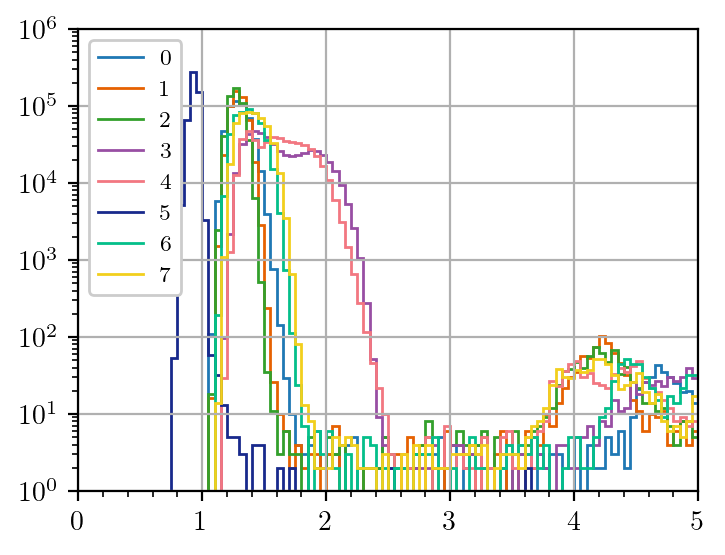

In [14]:
hists = get_bsl_rms_hist(data['Na22 2.7ppm'],np.arange(8),100,(0,5))
for i in range(8):
	plt.stairs(*(hists[i]),label=str(i))
plt.legend()
plt.yscale('log')
plt.grid()
plt.minorticks_on()

In [15]:
# Initialize Fprompt container
fprompt = {}
positions = ['all','window','no window']
groups = ['01234567','0356','1247']
fp_range = [(0.05,0.5,0.9), # 0ppm
            (0.04,0.45,0.9), # 0.1ppm
            (0.03,0.4,0.9), # 0.2ppm
            (0.03,0.35,0.9), # 0.3ppm
            (0.03,0.35,0.9), # 0.4ppm
            (0.03,0.3,0.9), # 0.7ppm
            (0.02,0.3,0.9), # 1.0ppm
            (0.02,0.25,0.9), # 1.5ppm
            (0.02,0.25,0.9), # 2.0ppm
            (0.02,0.25,0.9) # 2.7ppm
]

In [16]:
# Produce fprompt 2D histograms
binsx = 500
range_minx = -10
range_maxx = 1000
binsy = 500
range_miny = 0
range_maxy = 1

for i,c in enumerate(cond):
    sc = sources[i%2]
    fprompt[c] = get_fp_hist2d(data[c],groups,'0p30us',bins_xy=[binsx,binsy],range_xy=[[range_minx,range_maxx],[range_miny,range_maxy]],log_scale=True)
    if sc=='Na22':
    	fp_range_ = {'01234567':fp_range[i//2][:-1],'0356':fp_range[i//2][:-1],'1247':fp_range[i//2][:-1]}
    elif sc=='AmBe':
        fp_range_ = {'01234567':fp_range[i//2][1:],'0356':fp_range[i//2][1:],'1247':fp_range[i//2][1:]}
    df_fp_filt = get_fp_filt(data[c],groups,fp_range_,'0p30us')
    data[c][df_fp_filt.columns] = df_fp_filt
    df_fp_filt = None

/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] = np.log10(temp)
/tmp/ipykernel_1194805/2981200603.py:81: RuntimeWarning: divide by zero encountered in log10
  hist2d_g[g][2] =

/tmp/ipykernel_1194805/2254640881.py:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout(h_pad=5, w_pad=3)


Text(0.5, 0.1, '$N_{\\rm PE}$')

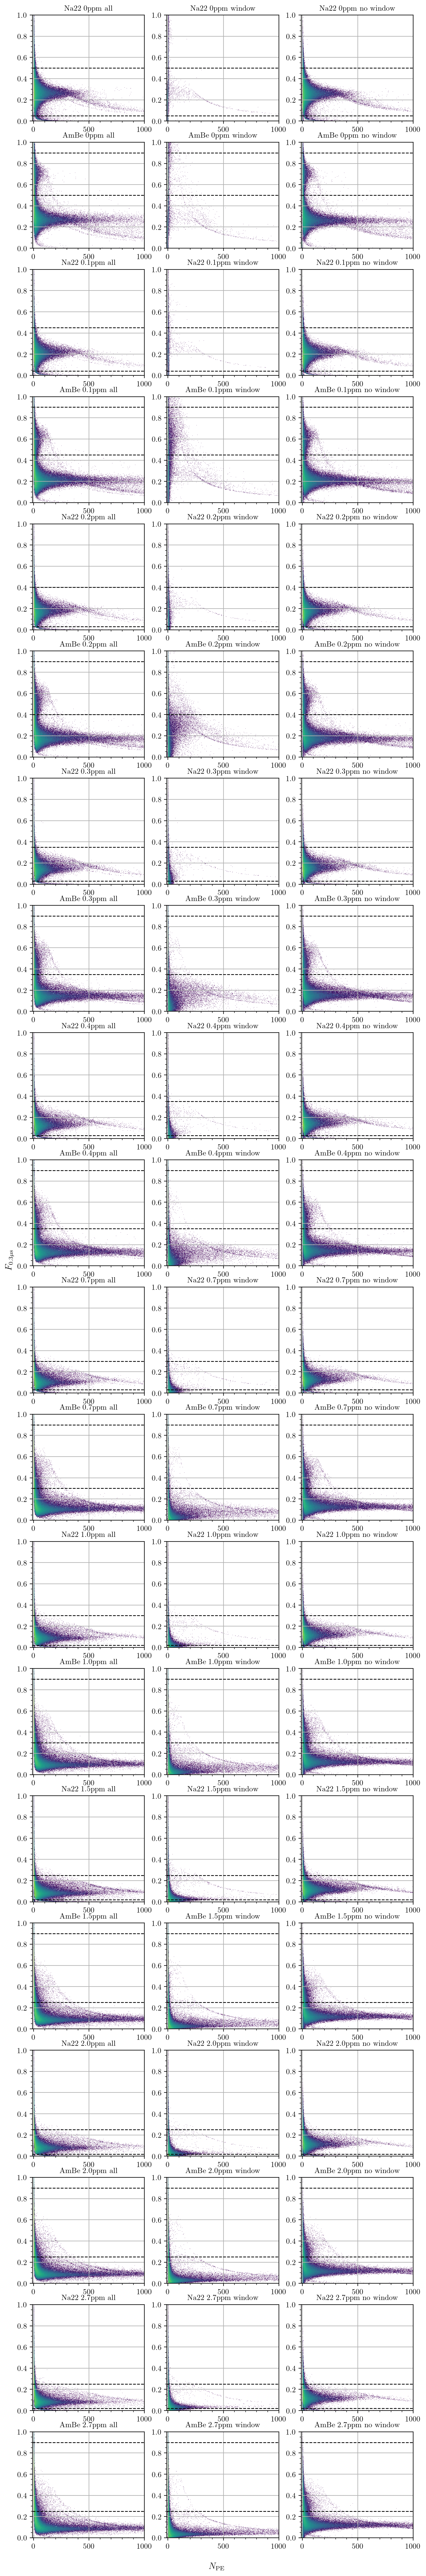

In [17]:
# Fprompt plots for all datasets
fig, axs = plt.subplots(len(cond), 3, sharex=False, sharey=False)
fig.tight_layout(h_pad=5, w_pad=3)
fig.set_size_inches(9, 3*len(cond))
for i,c in enumerate(cond):
    sc = sources[i%2]
    for j, (p,g) in enumerate(zip(positions,groups)):
        axs[i,j].pcolormesh(*fprompt[c][g])
        if sc=='Na22':
        	axs[i,j].plot([-10,range_maxx],[fp_range[i//2][0]]*2,'k--',linewidth=1)
        elif sc=='AmBe':
            axs[i,j].plot([-10,range_maxx],[fp_range[i//2][2]]*2,'k--',linewidth=1)
        axs[i,j].plot([-10,range_maxx],[fp_range[i//2][1]]*2,'k--',linewidth=1)
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c} {p}')
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0.07)
fig.supxlabel(r'$N_{\rm PE}$',y=0.1)

# Fprompt distribution in a PE slice

Text(0.5, 1.0, 'AmBe, $N_{\\rm PE,no \\,window}\\in$ (30,50)')

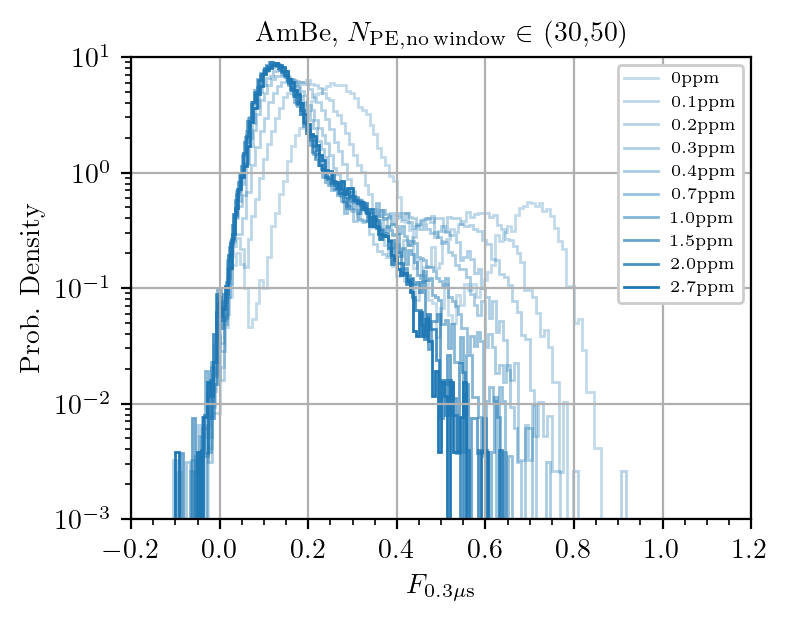

In [18]:
pe_range = (30,50)
for i,c in enumerate(cond):
    xe = xe_conc[i//2]
    if 'AmBe' in c:
        hist = np.histogram(data[c]['fprompt_0p30us_1247'][(data[c]['pe_1247']>pe_range[0]) & (data[c]['pe_1247']<pe_range[1])],bins=100)
        plt.stairs(hist[0]/np.sum(hist[0])/(hist[1][1]-hist[1][0]),hist[1],label=f'{c[5:]}',color='C0',alpha=(1+xe)/(1+xe_conc[-1]))
plt.xlabel(r'$F_{\rm 0.3\mu s}$')
plt.ylabel('Prob. Density')
plt.yscale('log')
plt.xlim(-0.2,1.2)
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper right',fontsize=6)
plt.title(r'AmBe, $N_{\rm PE,no \,window}\in$'+ ' ({:.0f},{:.0f})'.format(*pe_range))

In [19]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 500

fs_nofs_pe = {}
for c in cond:
    fs_nofs_pe[c] = {}
    bsl_filt = data[c]['bsl_filt']
    fs_nofs_pe[c]['counts'], fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins'] = np.histogram2d(
        data[c]['nofs_pe'][bsl_filt & data[c]['fp_filt_1247']], 
        data[c]['fs_pe'][bsl_filt & data[c]['fp_filt_1247']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fs_nofs_pe[c]['counts'] = fs_nofs_pe[c]['counts'].T
    fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins'] = np.meshgrid(
        fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins']
    )

/tmp/ipykernel_1194805/2968475672.py:9: RuntimeWarning: divide by zero encountered in log10
  np.log10(fs_nofs_pe[c]['counts'])


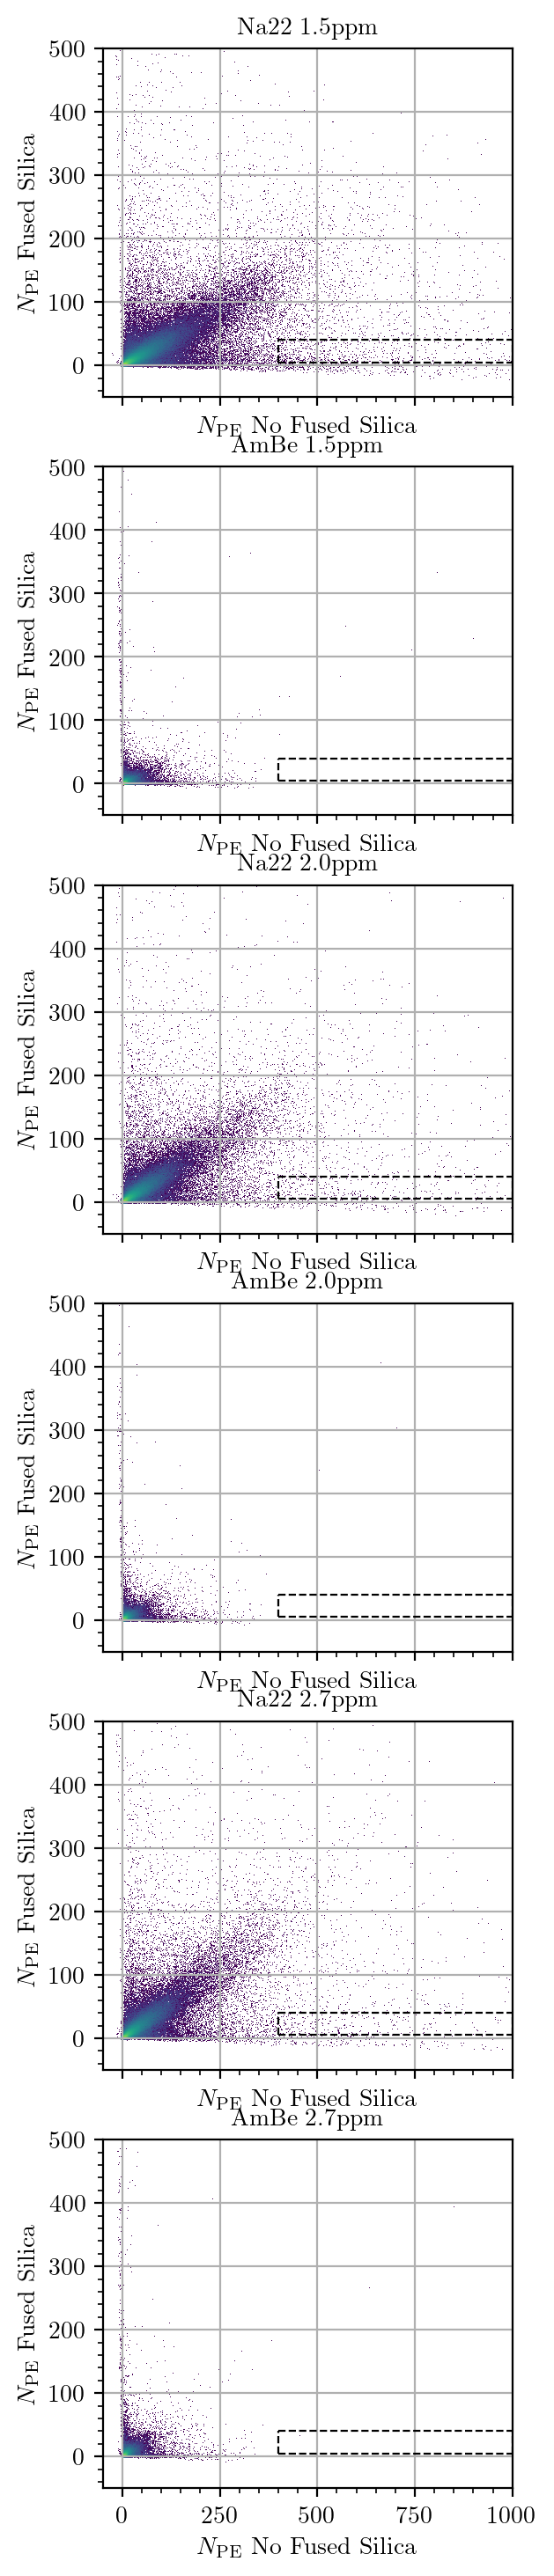

In [20]:
nrows = 6
fig, axs = plt.subplots(nrows, 1, sharex=True, sharey=True)
fig.set_size_inches(3, 3*nrows)
x1, y1, x2, y2 = 400, 5, 1000, 40
for i, c in enumerate(cond[-nrows:]):
    axs[i].pcolormesh(
        fs_nofs_pe[c]['xbins'],
        fs_nofs_pe[c]['ybins'],
        np.log10(fs_nofs_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 1000)
    axs[i].set_ylim(-50, 500)
    axs[i].set_xlabel(r'$N_{\rm PE}$ No Fused Silica')
    axs[i].set_ylabel(r'$N_{\rm PE}$ Fused Silica')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)

# mask_x, mask_y = (fs_nofs_pe[c]['xbins'][0,1:]<x2)&(fs_nofs_pe[c]['xbins'][0,1:]>x1), (fs_nofs_pe[c]['ybins'][1:,0]<y2)&(fs_nofs_pe[c]['ybins'][1:,0]>y1)
# bkg_scale = {}
# for c in cond[:-1]:
#     bkg_scale[c] = np.sum(fs_nofs_pe[c]['counts'][mask_y][:,mask_x])/np.sum(fs_nofs_pe['Background']['counts'][mask_y][:,mask_x])
#     print(f'Background to be scaled by {bkg_scale[c]} in {c} data')

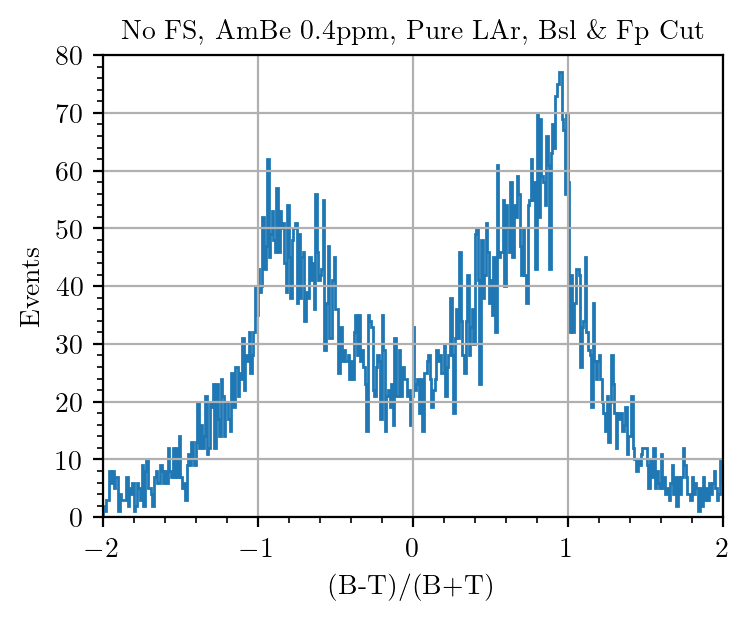

In [77]:
c = 'AmBe 0.4ppm'
filt = data[c]['bsl_filt'] & data[c]['fp_filt']
data[c]['tba_nofs'] = (data[c]['integral_10p00us_1']+data[c]['integral_10p00us_2']-data[c]['integral_10p00us_4']-data[c]['integral_10p00us_7'])/(data[c]['integral_10p00us_1']+data[c]['integral_10p00us_2']+data[c]['integral_10p00us_4']+data[c]['integral_10p00us_7'])
hist = np.histogram(data[c]['tba_nofs'][filt],bins=400,range=(-2,2));
plt.stairs(*hist)
plt.xlabel(r'(B-T)/(B+T)')
plt.ylabel('Events')
plt.title(f'No FS, {c}, Pure LAr, Bsl \& Fp Cut')
plt.grid()
plt.minorticks_on()

/tmp/ipykernel_1152491/3808960472.py:15: RuntimeWarning: divide by zero encountered in log10
  np.log10(tba_s1['counts'])


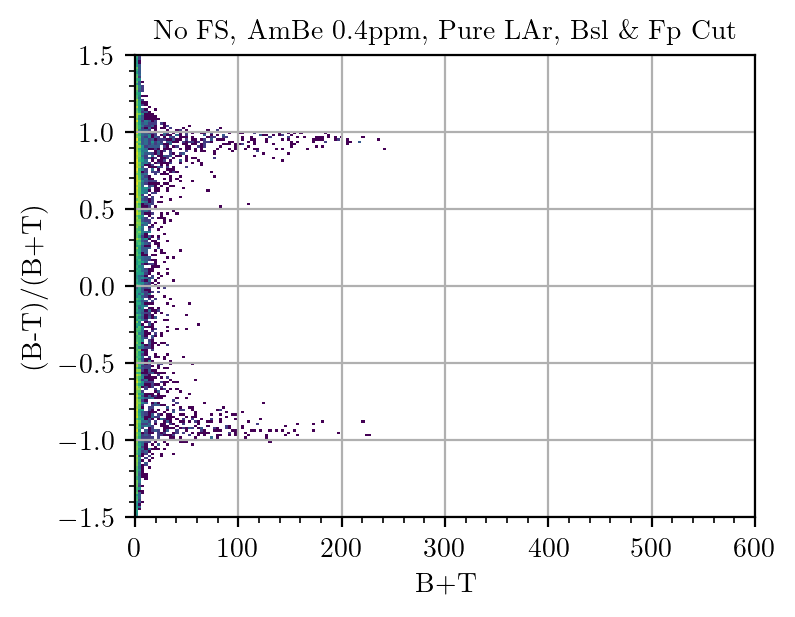

In [78]:
filt = data[c]['bsl_filt'] & data[c]['fp_filt']
tba_s1 = {}
tba_s1['counts'], tba_s1['xbins'], tba_s1['ybins'] = np.histogram2d(
	data[c]['nofs_pe'][filt], 
	data[c]['tba_nofs'][filt], 
	bins=[200,200], range=[[0,600],[-1.5,1.5]]
)
tba_s1['counts'] = tba_s1['counts'].T
tba_s1['xbins'], tba_s1['ybins'] = np.meshgrid(
	tba_s1['xbins'], tba_s1['ybins']
)
plt.pcolormesh(
	tba_s1['xbins'],
	tba_s1['ybins'],
	np.log10(tba_s1['counts'])
)
plt.xlabel(r'B+T')
plt.ylabel(r'(B-T)/(B+T)')
plt.title(f'No FS, {c}, Pure LAr, Bsl \& Fp Cut')
plt.grid()
plt.minorticks_on()

In [21]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [22]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 4000
            nbins = 6000
        elif w=='no':
            range_min = -10
            range_max = 4000
            nbins = 6000
        filt = data[c]['bsl_filt'] & data[c]['fp_filt_1247']
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['nofs_pe'][filt] if w=='no' else data[c]['fs_pe'][filt], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])

Text(0.0, 0.5, 'Probability density [1/PE]')

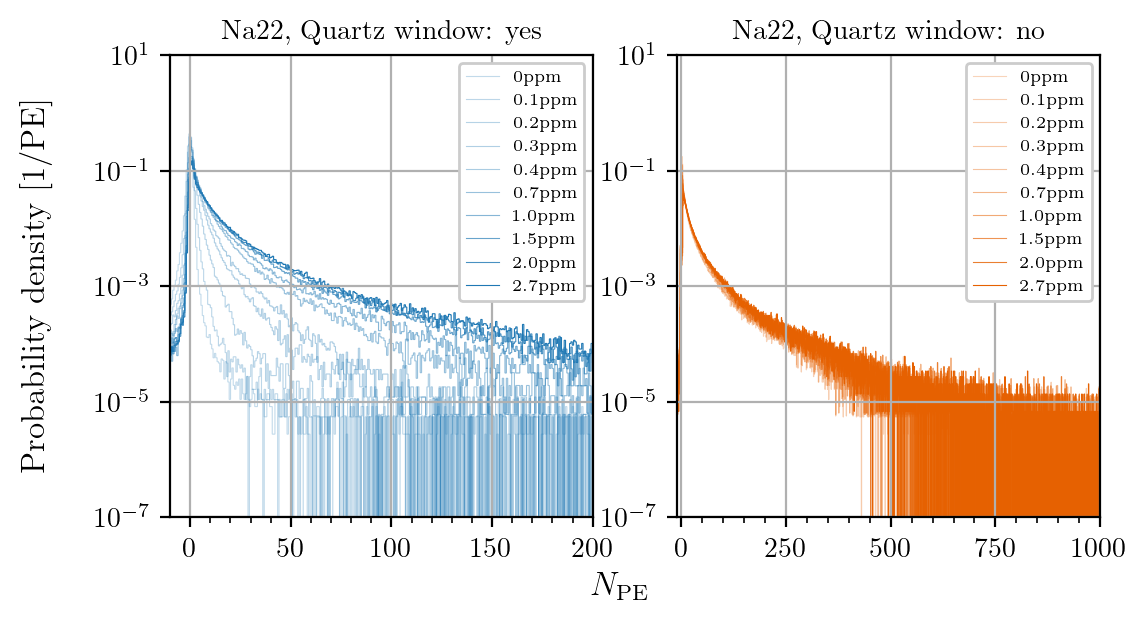

In [23]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 3)

for j, w in enumerate(window):
    for i, c in enumerate(cond):
        xe = xe_conc[i//2]
        if 'AmBe' not in c:
            if w=='yes':
                sideband_range = (spectra[c][w]['bins'][0],spectra[c][w]['bins'][-1])
                sideband_sum = np.sum(spectra[c][w]['counts'][(spectra[c][w]['bins'][1:]>sideband_range[0]) & (spectra[c][w]['bins'][1:]<sideband_range[1])])
                # sideband_sum = 1
                bw = spectra[c][w]['bins'][1]-spectra[c][w]['bins'][0]
                axs[j].stairs(
					spectra[c][w]['counts']/sideband_sum/bw, spectra[c][w]['bins'], 
					label=f'{xe}ppm', color='C0', alpha=(1+xe)/(1+xe_conc[-1]), linewidth=0.4
				)
            else:
                sideband_range = (spectra[c][w]['bins'][0],spectra[c][w]['bins'][-1])
                sideband_sum = np.sum(spectra[c][w]['counts'][(spectra[c][w]['bins'][1:]>sideband_range[0]) & (spectra[c][w]['bins'][1:]<sideband_range[1])])
                # sideband_sum = 1
                bw = spectra[c][w]['bins'][1]-spectra[c][w]['bins'][0]
                axs[j].stairs(
					spectra[c][w]['counts']/sideband_sum/bw, spectra[c][w]['bins'], 
					label=f'{xe}ppm', color='C1', alpha=(1+xe)/(1+xe_conc[-1]), linewidth=0.4
				)
    axs[j].legend(loc='upper right',fontsize=6)
    axs[j].set_ylim(1e-7, 1e1)
    if w=='yes':
        axs[j].set_xlim(-10,200)
    else:
    	axs[j].set_xlim(-10,1000)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Na22, Quartz window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.03)
fig.supylabel('Probability density [1/PE]', x=0.0)

Text(0.0, 0.5, 'Probability density [1/PE]')

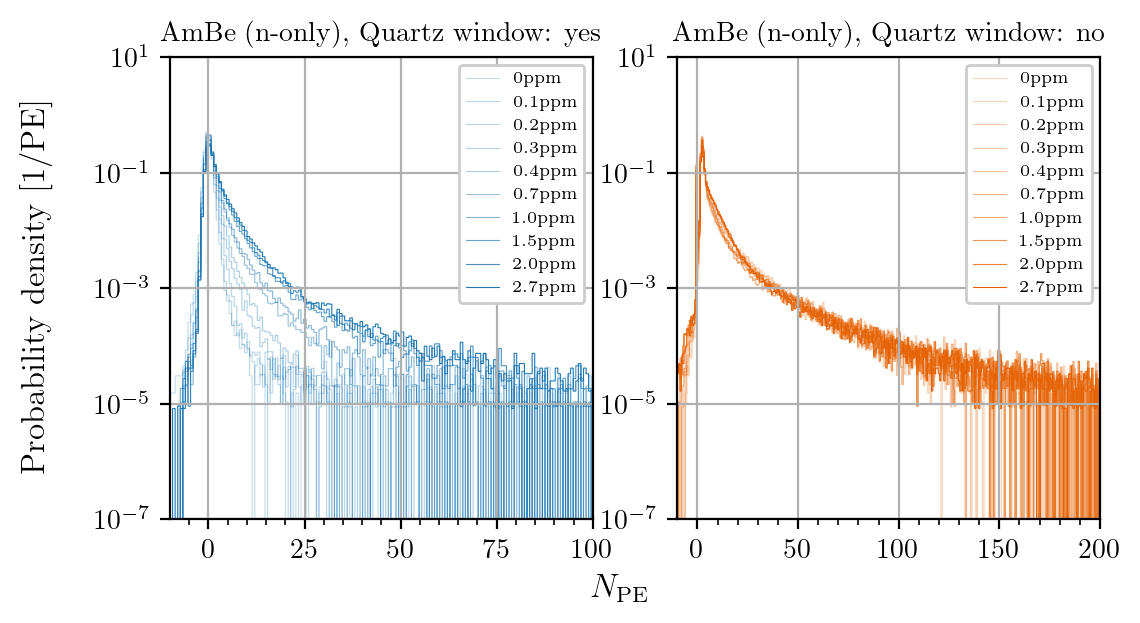

In [25]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_size_inches(6, 3)

for j, w in enumerate(window):
    for i, c in enumerate(cond):
        xe = xe_conc[i//2]
        if 'AmBe' in c:
            if w=='yes':
                sideband_range = (spectra[c][w]['bins'][0],spectra[c][w]['bins'][-1])
                sideband_sum = np.sum(spectra[c][w]['counts'][(spectra[c][w]['bins'][1:]>sideband_range[0]) & (spectra[c][w]['bins'][1:]<sideband_range[1])])
                # sideband_sum = 1
                bw = spectra[c][w]['bins'][1]-spectra[c][w]['bins'][0]
                axs[j].stairs(
					spectra[c][w]['counts']/sideband_sum/bw, spectra[c][w]['bins'], 
					label=f'{xe}ppm', color='C0', alpha=(1+xe)/(1+xe_conc[-1]), linewidth=0.4
				)
            else:
                sideband_range = (spectra[c][w]['bins'][0],spectra[c][w]['bins'][-1])
                sideband_sum = np.sum(spectra[c][w]['counts'][(spectra[c][w]['bins'][1:]>sideband_range[0]) & (spectra[c][w]['bins'][1:]<sideband_range[1])])
                # sideband_sum = 1
                bw = spectra[c][w]['bins'][1]-spectra[c][w]['bins'][0]
                axs[j].stairs(
					spectra[c][w]['counts']/sideband_sum/bw, spectra[c][w]['bins'], 
					label=f'{xe}ppm', color='C1', alpha=(1+xe)/(1+xe_conc[-1]), linewidth=0.4
				)
    axs[j].legend(loc='upper right',fontsize=6)
    axs[j].set_ylim(1e-7, 1e1)
    if w=='yes':
        axs[j].set_xlim(-10,100)
    else:
    	axs[j].set_xlim(-10,200)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'AmBe (n-only), Quartz window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.03)
fig.supylabel('Probability density [1/PE]', x=0.0)

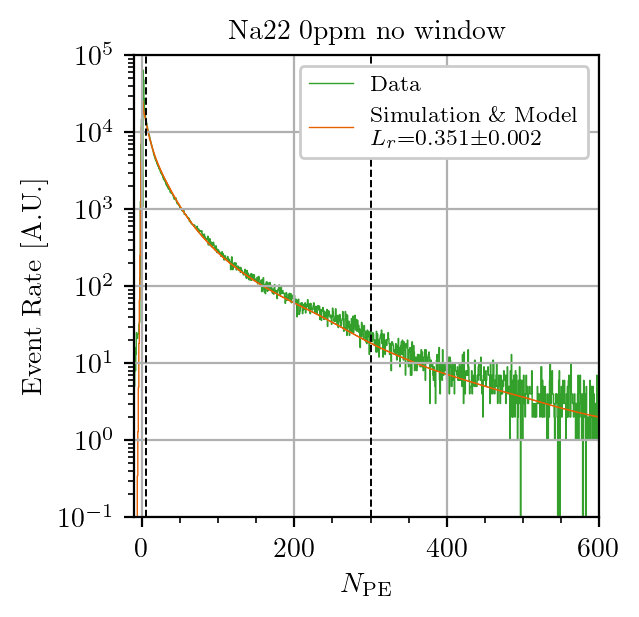

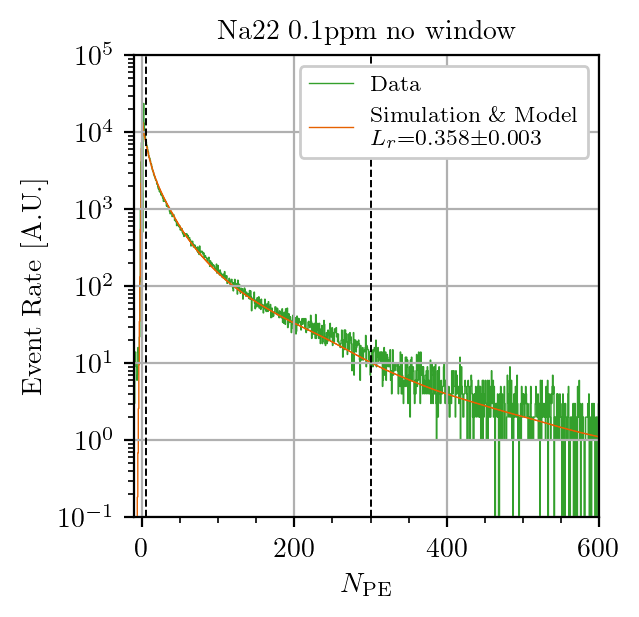

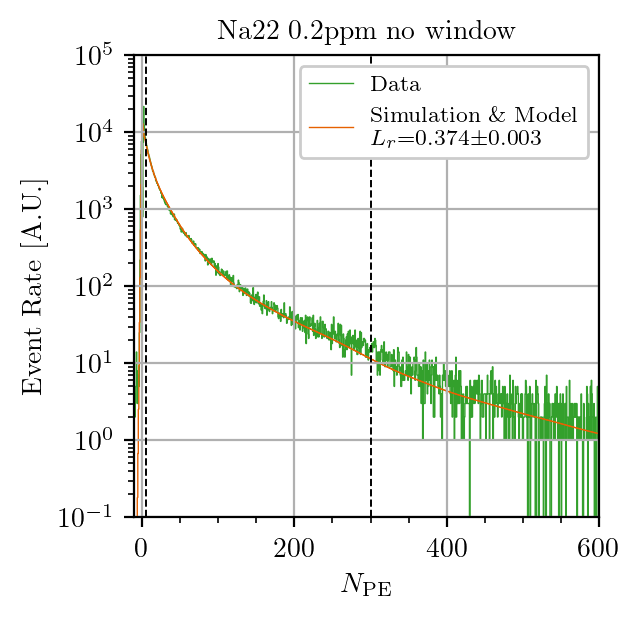

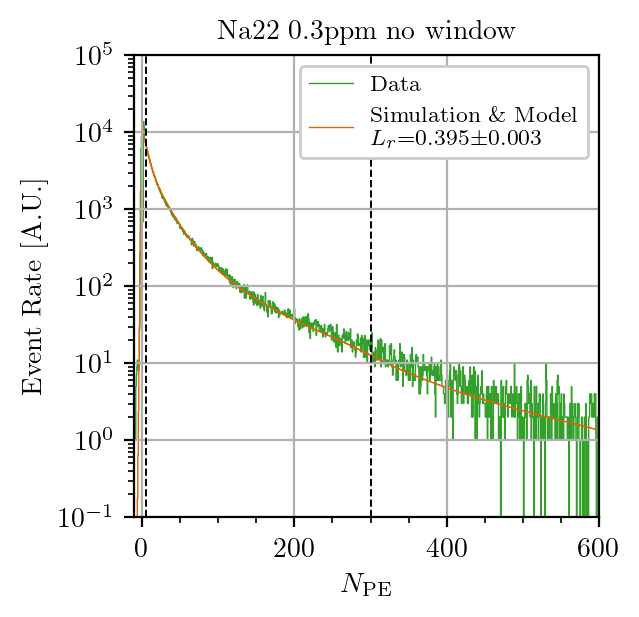

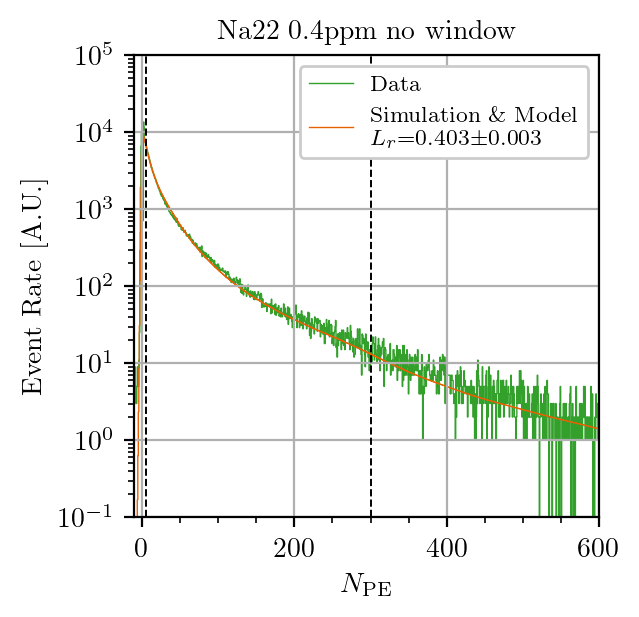

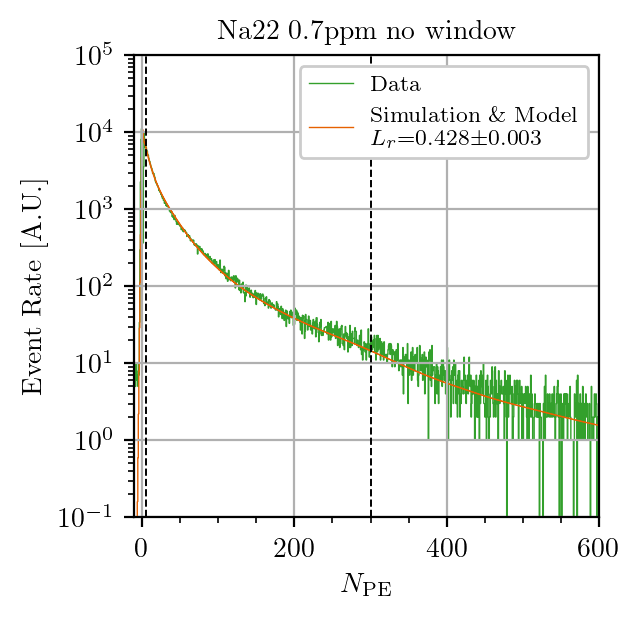

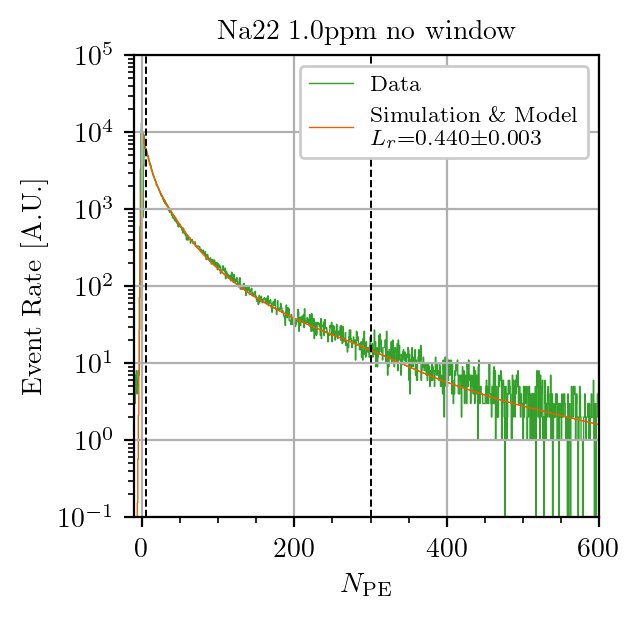

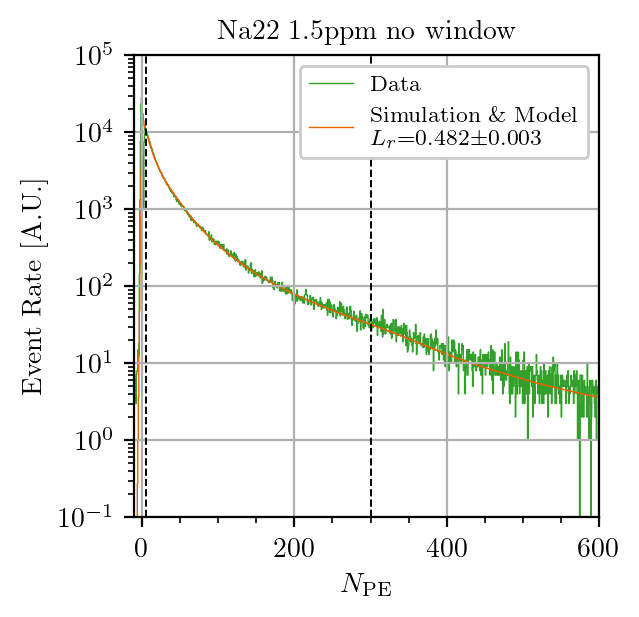

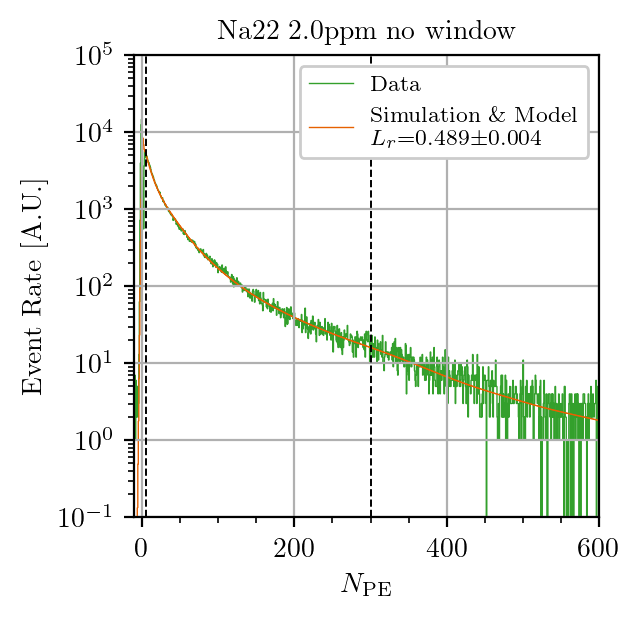

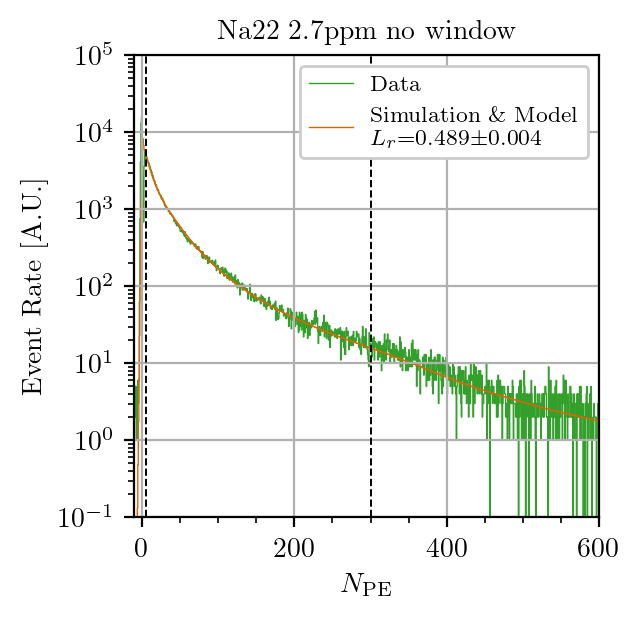

In [26]:
ly0 = {}
ly0_err = {}
for i,c in enumerate(cond):
	if 'Na22' in c:
		plt.figure(i,figsize=(3,3))
		fit_range = (5,300)
		ymin, ymax = 1e-1,1e8
		smear = DetectorSmearing(fano=np.mean(calib[98]['fano'][[1,2,4,7]]),hist_in=hist_sim['Na-22'])
		par,cov = smear.fit_to_data(
			data=(spectra[c]['no']['counts'],spectra[c]['no']['bins']),
			sigma=spectra[c]['no']['errs'],
			x0=[5e5,0.4],
			fit_range=fit_range
		)
		par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
		ly0[c] = par[1]
		ly0_err[c] = par_err[1]
		plt.stairs(spectra[c]['no']['counts'],spectra[c]['no']['bins'], label='Data', color='C2', linewidth=0.5)
		plt.stairs(*(smear.get_spectrum(spectra[c]['no']['bins'],*par)), label='Simulation \& Model\n'+r'$L_r$='+f'{par[1]:.3f}'+r'$\pm$'+f'{par_err[1]:.3f}', color='C1', linewidth=0.5)
		plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
		plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
		plt.yscale('log')
		plt.minorticks_on()
		plt.grid()
		plt.ylim(1e-1,1e5)
		plt.xlim(-10,600)
		plt.legend(loc='upper right')
		plt.title(f'{c} no window')
		plt.xlabel(r'$N_{\rm PE}$')
		plt.ylabel(r'Event Rate [A.U.]')

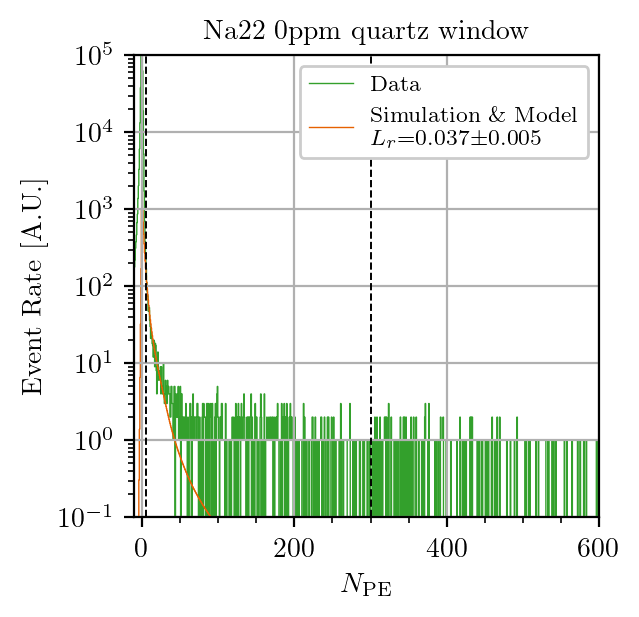

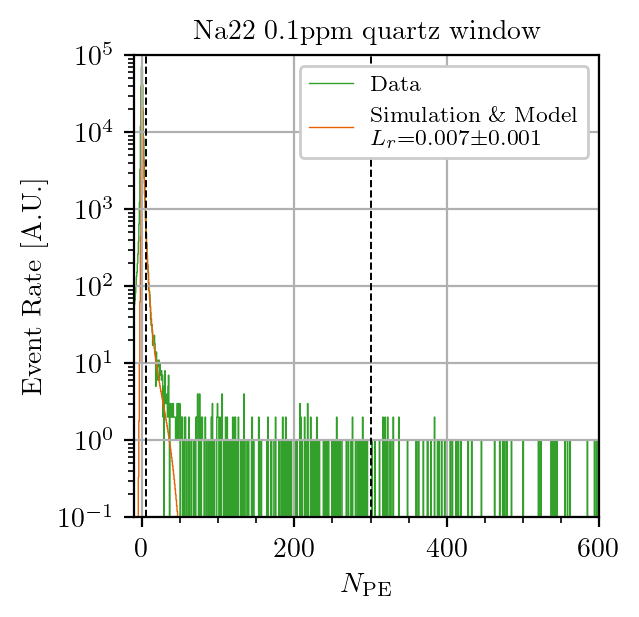

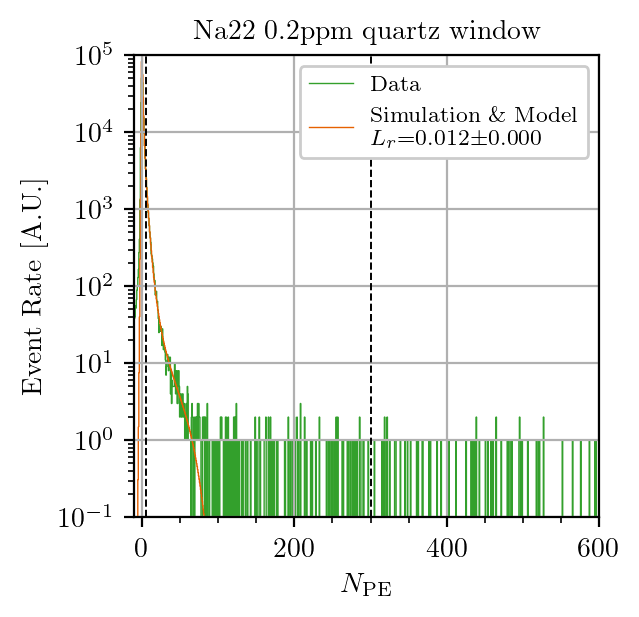

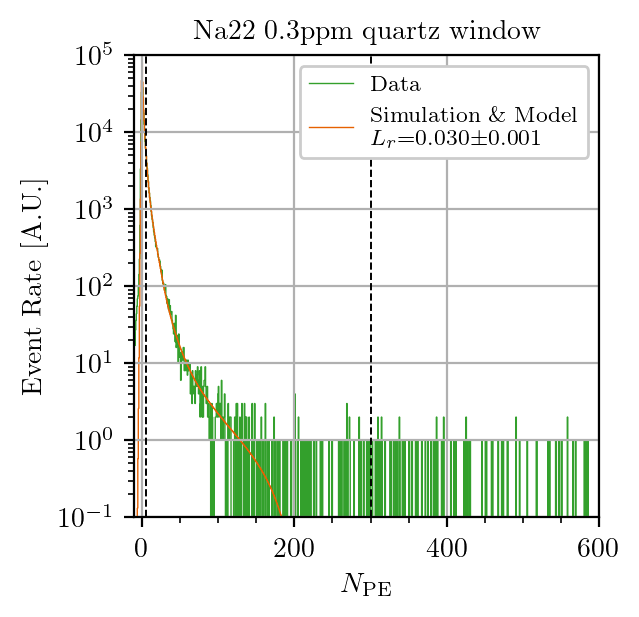

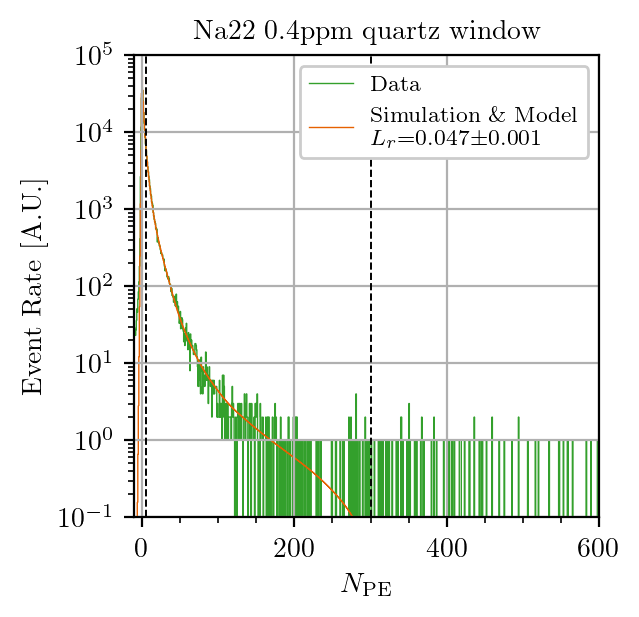

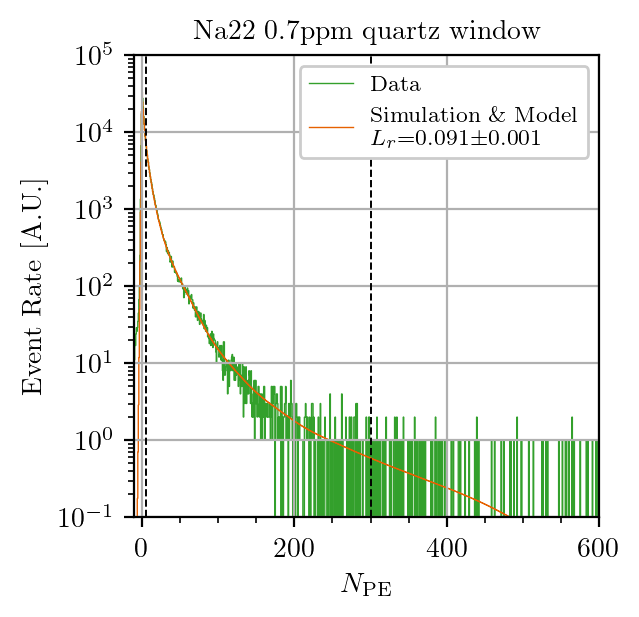

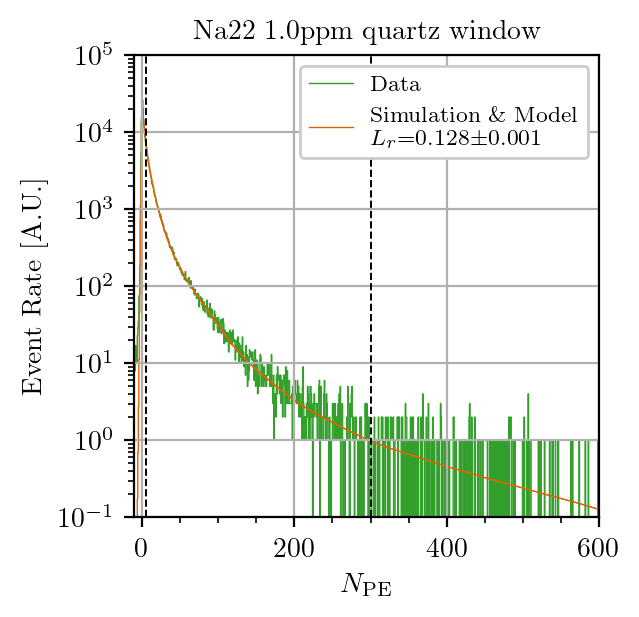

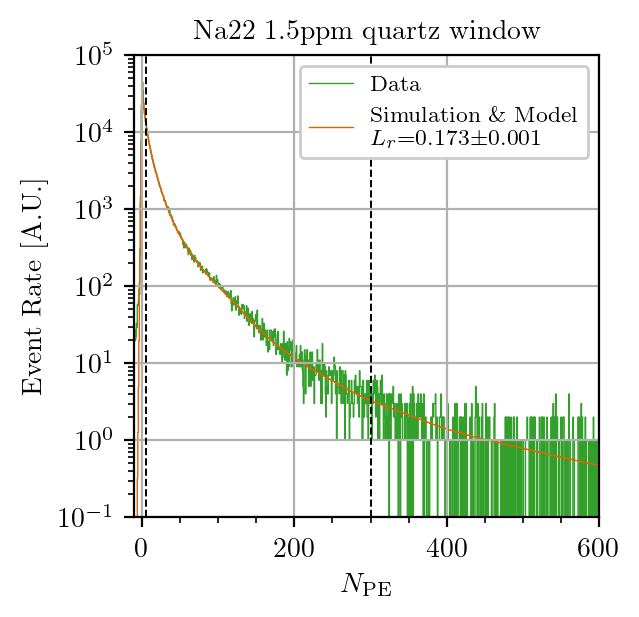

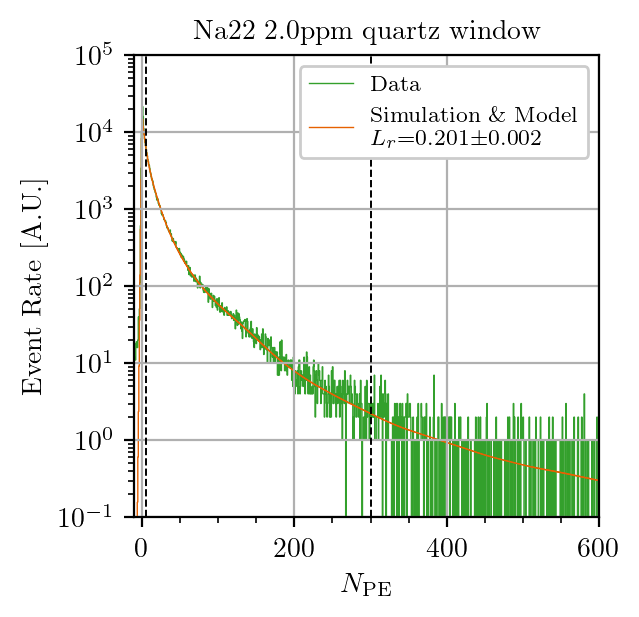

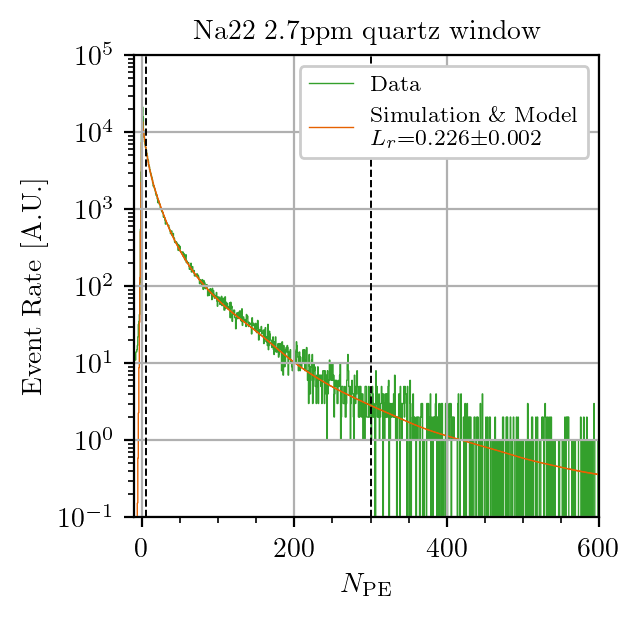

In [27]:
ly0_w = {}
ly0_w_err = {}
for i,c in enumerate(cond):
	if 'Na22' in c:
		plt.figure(i,figsize=(3,3))
		fit_range = (5,300)
		ymin, ymax = 1e-1,1e8
		smear = DetectorSmearing(fano=np.mean(calib[98]['fano'][[1,2,4,7]]),hist_in=hist_sim['Na-22'])
		par,cov = smear.fit_to_data(
			data=(spectra[c]['yes']['counts'],spectra[c]['yes']['bins']),
			sigma=spectra[c]['yes']['errs'],
			x0=[5e5,0.1],
			fit_range=fit_range
		)
		par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
		ly0_w[c] = par[1]
		ly0_w_err[c] = par_err[1]
		plt.stairs(spectra[c]['yes']['counts'],spectra[c]['yes']['bins'], label='Data', color='C2', linewidth=0.5)
		plt.stairs(*(smear.get_spectrum(spectra[c]['yes']['bins'],*par)), label='Simulation \& Model\n'+r'$L_r$='+f'{par[1]:.3f}'+r'$\pm$'+f'{par_err[1]:.3f}', color='C1', linewidth=0.5)
		plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
		plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
		plt.yscale('log')
		plt.minorticks_on()
		plt.grid()
		plt.ylim(1e-1,1e5)
		plt.xlim(-10,600)
		plt.legend(loc='upper right')
		plt.title(f'{c} quartz window')
		plt.xlabel(r'$N_{\rm PE}$')
		plt.ylabel(r'Event Rate [A.U.]')

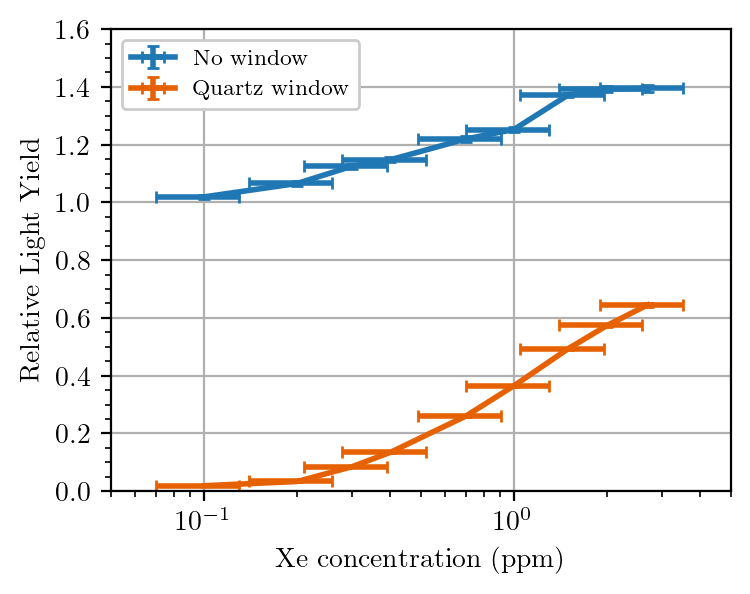

In [28]:
xe_arr = np.array(xe_conc)[1:]
xe_err_arr = xe_arr*0.3
ly_arr = np.array(list(ly0.values()))[1:]/ly0['Na22 0ppm']
ly_err_arr = np.array(list(ly0_err.values()))[1:]/ly0['Na22 0ppm']
ly_w_arr = np.array(list(ly0_w.values()))[1:]/ly0['Na22 0ppm']
ly_w_err_arr = np.array(list(ly0_w_err.values()))[1:]/ly0['Na22 0ppm']
plt.errorbar(y=ly_arr,x=xe_arr,yerr=ly_err_arr,xerr=xe_err_arr,label='No window')
plt.errorbar(y=ly_w_arr,x=xe_arr,yerr=ly_w_err_arr,xerr=xe_err_arr,label='Quartz window')
plt.xlabel('Xe concentration (ppm)')
plt.ylabel('Relative Light Yield')
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper left')
plt.xlim(0.05,5)
plt.xscale('log')

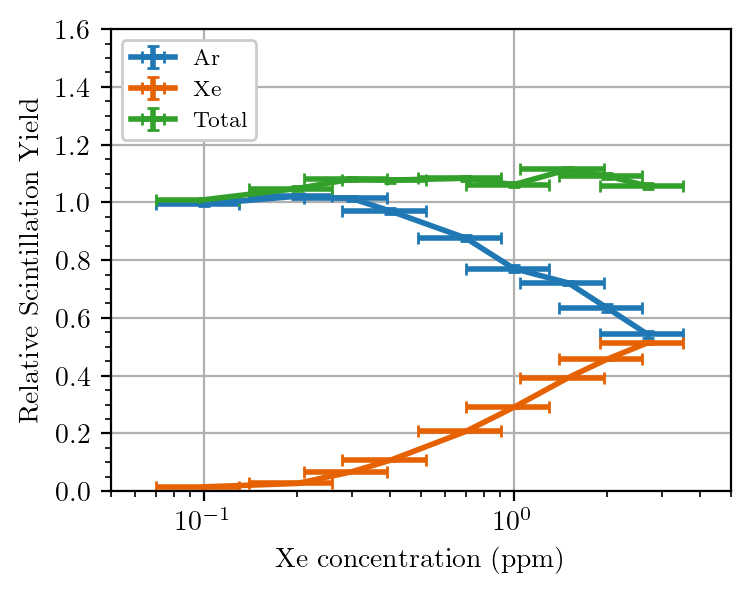

In [29]:
pde_ar = 14.3
pde_xe = 23.7
rel_eff = 1.32
sy_ar = ly_arr-ly_w_arr*rel_eff
sy_ar_err = (ly_err_arr**2 + (rel_eff*ly_w_err_arr)**2)**0.5
sy_xe = ly_w_arr*rel_eff*pde_ar/pde_xe
sy_xe_err = ly_w_err_arr*rel_eff*pde_ar/pde_xe
sy_tot = ly_arr+ly_w_arr*rel_eff*(pde_ar/pde_xe-1)
sy_tot_err = (ly_err_arr**2 + (ly_w_err_arr*rel_eff*(pde_ar/pde_xe-1))**2)**0.5
plt.errorbar(y=sy_ar,x=xe_arr,yerr=sy_ar_err,xerr=xe_err_arr,label='Ar')
plt.errorbar(y=sy_xe,x=xe_arr,yerr=sy_xe_err,xerr=xe_err_arr,label='Xe')
plt.errorbar(y=sy_tot,x=xe_arr,yerr=sy_tot_err,xerr=xe_err_arr,label='Total')
plt.xlabel('Xe concentration (ppm)')
plt.ylabel('Relative Scintillation Yield')
plt.grid()
plt.minorticks_on()
plt.legend(loc='upper left')
plt.xlim(0.05,5)
plt.ylim(0,1.6)
plt.xscale('log')